Decoding the IAPS dataset (neurovault collection id 503)
--
## GSP

### Load BASC dataset & divide non connected regions + Coordinates of regions

In [3]:
from nilearn.datasets import fetch_neurovault_ids
from nilearn.image import threshold_img
from nilearn.plotting import plot_roi
from nilearn.datasets import fetch_icbm152_brain_gm_mask
from nilearn.image import resample_img,math_img
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline
from nilearn.input_data import NiftiMasker

In [4]:
import numpy as np
from nilearn import datasets
from nilearn.regions import connected_label_regions
from nilearn.plotting import find_xyz_cut_coords 
# Basc
basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')['scale444']
# Create atlas with no unconnected regions
basc_regions = connected_label_regions(basc)     
# Calculate coordinates
atlas_data = basc_regions.get_data()         
all_labels = np.unique(atlas_data)
# remove the 0. value which correspond to voxels out of ROIs
all_labels = all_labels[1:]  
allcoords=[]
for i,curlabel in enumerate(all_labels):
    img_curlab = math_img(formula="img==%d"%curlabel,img=basc_regions)
    allcoords.append(find_xyz_cut_coords(img_curlab))
allcoords=np.array(allcoords)

In [5]:
### WARNING - This will download the whole collection (> 5000 images) , without resampling it will be more > 9 Go
IAPSdata  = fetch_neurovault_ids(collection_ids=[503],data_dir='/home/nfarrugi/datasets/IAPS')





Dataset created in /home/nfarrugi/datasets/IAPS/neurovault

Reading local neurovault data.
No image found on local disk.
Reading server neurovault data.
getting new batch: http://neurovault.org/api/collections/503
Scroll images from collection 503: getting new batch: http://neurovault.org/api/collections/503/images/?limit=100&offset=0
Scroll images from collection 503: batch size: 100
Download succeeded, downloaded to: /home/nfarrugi/datasets/IAPS/neurovault/collection_503/image_3647.nii.gz
Already fetched 1 image
Download succeeded, downloaded to: /home/nfarrugi/datasets/IAPS/neurovault/collection_503/image_3648.nii.gz
Already fetched 2 images
Download succeeded, downloaded to: /home/nfarrugi/datasets/IAPS/neurovault/collection_503/image_3651.nii.gz
Already fetched 3 images
Download succeeded, downloaded to: /home/nfarrugi/datasets/IAPS/neurovault/collection_503/image_3655.nii.gz
Already fetched 4 images
Download succeeded, downloaded to: /home/nfarrugi/datasets/IAPS/neurovault/colle

Checking whether all images are in MNI 

In [6]:
all_mni = [not(image_not_mni['not_mni']) for image_not_mni in IAPSdata.images_meta]
np.alltrue(all_mni)

False

Testing visualization of a bunch of images 

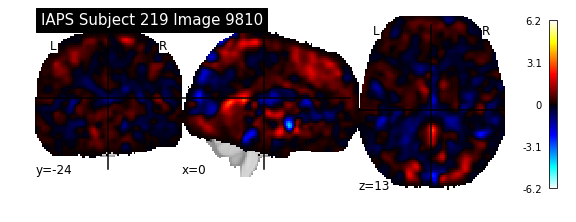

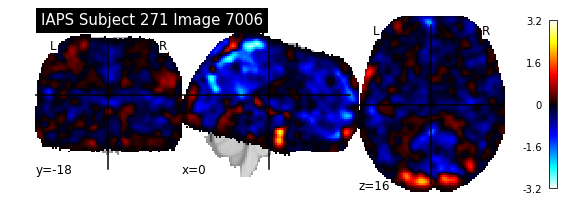

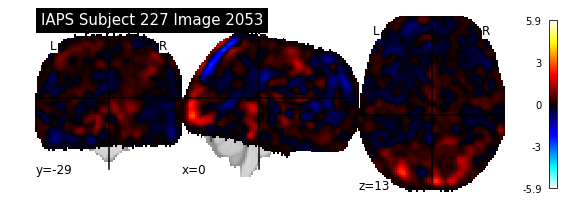

In [7]:

# We'll fetch a total of images specified here 
numberofguys=3

for i in range(numberofguys):
    #pick one guy randomly
    im_ind_rand = np.random.randint(len(IAPSdata.images))

    plot_stat_map(IAPSdata.images[im_ind_rand],title=IAPSdata.images_meta[im_ind_rand]['name'])
    plt.show()

Preparing the MNI mask subsampled at 4mm

/home/nfarrugi/miniconda3/envs/tf/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int8 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


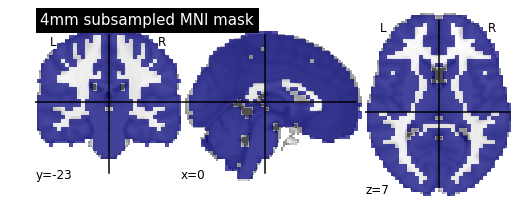

In [8]:
# Preparing mni mask at 4x4x4 
mni_mask = fetch_icbm152_brain_gm_mask()
target_affine_4mm = np.diag([4,4,4])
mni_mask_resampled = resample_img(mni_mask, target_affine_4mm)

# Values need to be thresholded 

mni_mask_resampled_thre = threshold_img(mni_mask_resampled,threshold=0.5)
plot_roi(mni_mask_resampled_thre,title='4mm subsampled MNI mask')
plt.show()


We select train and test images

In [9]:
### Generate Train and Test list
# Parcellate the subset of images and select the ratings 
from nilearn.datasets import load_mni152_brain_mask
from nilearn.input_data import NiftiLabelsMasker
# Load MNI mask
brainmask = load_mni152_brain_mask()
# masker for plotting 
masker = NiftiLabelsMasker(labels_img = basc_regions, mask_img = mni_mask_resampled_thre, 
                           memory_level=1, verbose=0,
                           resampling_target='labels'
                           )
masker.fit()

   
X_train=[]
X_test=[]
y_train=[]
y_test=[]
for curind in range(len(IAPSdata.images)):
    if 'Train' in IAPSdata.images_meta[curind]['Holdout']:
        curim = IAPSdata.images[curind]
        currating = IAPSdata.images_meta[curind]['Rating']
    #print('parcellating %s' % curim)
        X_train.append(masker.transform(curim))
        y_train.append(currating)
    elif 'Test' in IAPSdata.images_meta[curind]['Holdout']:
        curim = IAPSdata.images[curind]
        currating = IAPSdata.images_meta[curind]['Rating']
    #print('parcellating %s' % curim)
        X_test.append(masker.transform(curim))
        y_test.append(currating)
    
X_test = np.vstack(X_test)
y_test = np.stack(y_test)
X_train = np.vstack(X_train)
y_train = np.stack(y_train)

In [10]:
X_test[1,:].reshape((1,523)).shape

(1, 523)

In [11]:
# save masked data on local
X_test.tofile('X_test_basc.npz')
X_train.tofile('X_train_basc.npz')
y_test.tofile('y_test_basc.npz')
y_train.tofile('y_train_basc.npz')

Let's look at a few masked and resampled images 

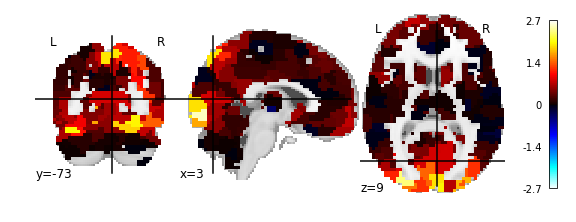

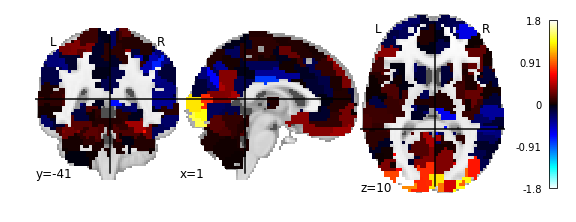

In [12]:
for curx in X_test[:2]:
    testim = masker.inverse_transform(curx.reshape((1,523)))
    plot_stat_map(testim)
    plt.show()

(array([ 809.,    0.,  207.,    0.,    0.,  246.,    0.,  229.,    0.,  201.]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

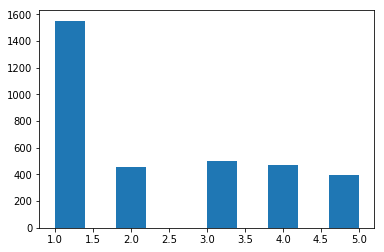

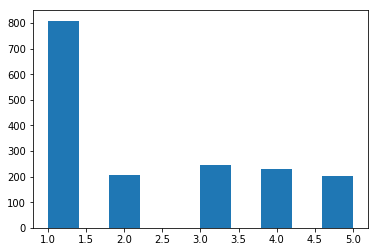

In [13]:
plt.hist(y_train)
plt.figure()
plt.hist(y_test)

Keeping only  high and low ratings 

In [14]:
ind_lh = (y_train<2)|(y_train >4)
y_train_lowhigh = y_train[ind_lh]
X_train_lowhigh  = X_train[ind_lh]
ind_lh = (y_test<2)|(y_test >4)
y_test_lowhigh = y_test[ind_lh]
X_test_lowhigh  = X_test[ind_lh]

## Prepare Classification

In [27]:
allcoords.shape

(523, 3)

In [15]:
from sklearn.feature_selection import f_regression, SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
##### Parameters for Classification 
scaler = StandardScaler()
svm= SVC(C=1., kernel="linear",class_weight='balanced')  
logistic = LogisticRegression(C=1., penalty="l1")
logistic_l2 = LogisticRegression(C=1., penalty="l2")
# A dictionary, to hold all our classifiers
classifiers = {'SVC': svm,
           'log_l1': logistic,
           'log_l2': logistic_l2
           }

for k in (5,10,20,50,80,100,150,200,300):
##### Parameters for Dimension Reduction
    feature_selection = SelectKBest(f_classif, k=k)
    pca = PCA(n_components=k)
    ica=FastICA(n_components=k)

    reductionlist = { 'anova'+str(k):feature_selection,
            # 'ica'+str(k):ica,
             'pca'+str(k):pca,
            } 

    pipeline_anova = Pipeline([('anova', feature_selection), ('scale', scaler),('classif_name', svm)])
    pipeline = Pipeline([('scaler',scaler), ('svm', svm)])

#pipeline.fit(X_train,y_train)
#print('score',pipeline.score(X_test,y_test))

    for red_name, red in sorted(reductionlist.items()):
        pipeline_red=Pipeline([('reduction',red),('scaler',scaler), ('svm', svm)])
        pipeline_red.fit(X_train_lowhigh,y_train_lowhigh)
        print('score',red_name,pipeline_red.score(X_test_lowhigh,y_test_lowhigh))

score anova5 0.754455445545
score pca5 0.650495049505
score anova10 0.752475247525
score pca10 0.705940594059
score anova20 0.784158415842
score pca20 0.811881188119
score anova50 0.783168316832
score pca50 0.864356435644
score anova80 0.790099009901
score pca80 0.859405940594
score anova100 0.778217821782
score pca100 0.861386138614
score anova150 0.80099009901
score pca150 0.834653465347
score anova200 0.815841584158
score pca200 0.836633663366
score anova300 0.80297029703
score pca300 0.835643564356


In [30]:
X_train_lowhigh.shape

(1949, 523)

Prepare GSP

In [28]:
from gsplearn.GSPTransform import GraphTransformer

# Graph to build with dictionary of parameters
graphsname = {'g_full':{'kind':'geometric','method':'distance','spars':1,'geoalpha':0.0001},
              'g_bingeo':{'kind':'geometric','method':'binary','spars':0.2,'geoalpha':0.0001},
              'g_distgeo':{'kind':'geometric','method':'distance','spars':0.2,'geoalpha':0.0001},
              'g_semilocal':{'kind':'mixed','method':'covariance','spars':0.5,'geoalpha':0.0001},
              'g_func_full':{'kind':'functional','method':'covariance','spars':1,'geoalpha':0.0001},
              'g_func_0.7':{'kind':'functional','method':'covariance','spars':0.7,'geoalpha':0.0001},
                        } 
verbose=0
absolute=False
geo_alpha=0.0001


## High frequencies 
fmin=261
fmax=523

## Low frequencies 
#fmin=0
#fmax=150
k=100

Let's see what happens when training on only rating 1 Vs rating 5

In [19]:
k=50
##### Parameters for Dimension Reduction
feature_selection = SelectKBest(f_classif, k=k)
pca = PCA(n_components=k)
ica=FastICA(n_components=k)

reductionlist = { 'anova'+str(k):feature_selection,
            # 'ica'+str(k):ica,
             'pca'+str(k):pca,
            } 
pipeline_anova = Pipeline([('anova', feature_selection), ('scale', scaler),('classif_name', svm)])

Baseline score with an MLP

In [39]:
np.savez("coords.npz",allcoords)


In [37]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(500,500,))

pipeline_mlp = Pipeline([('scaler',scaler), ('MLP', mlp)])

pipeline_mlp.fit(X_train_lowhigh,y_train_lowhigh)
print('score',pipeline_mlp.score(X_test_lowhigh,y_test_lowhigh))


score 0.868316831683


In [31]:
pipeline.fit(X_train_lowhigh,y_train_lowhigh)
print('score',pipeline.score(X_test_lowhigh,y_test_lowhigh))

for red_name, red in sorted(reductionlist.items()):
    pipeline_red=Pipeline([('reduction',red),('scaler',scaler), ('svm', svm)])
    pipeline_red.fit(X_train_lowhigh,y_train_lowhigh)
    print('score',red_name,pipeline_red.score(X_test_lowhigh,y_test_lowhigh))
  


score 0.824752475248
score anova50 0.783168316832
score pca50 0.869306930693


In [23]:
from gsplearn.GSPTransform import GraphTransformer
# Graph to build with dictionary of parameters
graphsname = {'g_full':{'kind':'geometric','method':'distance','spars':1,'geoalpha':0.0001},
              'g_bingeo':{'kind':'geometric','method':'binary','spars':0.2,'geoalpha':0.0001},
              'g_distgeo':{'kind':'geometric','method':'distance','spars':0.2,'geoalpha':0.0001},
              'g_semilocal':{'kind':'mixed','method':'covariance','spars':0.5,'geoalpha':0.0001},
              'g_func_full':{'kind':'functional','method':'covariance','spars':1,'geoalpha':0.0001},
              'g_func_0.7':{'kind':'functional','method':'covariance','spars':0.8,'geoalpha':0.0001},
                        } 
verbose=0
absolute=True
geo_alpha=0.0001
#fmin=261
#fmax=523
fmin=0
fmax=261

In [29]:
for graph_name, param in sorted(graphsname.items()): 
    gr=GraphTransformer(rest=X_train,coords=allcoords, 
                                    verbose=verbose,kind=param['kind'],
                                    method=param['method'],
                                    spars=param['spars'],
                                    geo_alpha=param['geoalpha']
                                )
    gr.fit(X_train_lowhigh)           

    # Sampling train and test data
    X_train_sampled, idex=gr.sample(X_train_lowhigh,k,fmin,fmax)
    X_test_sampled, idex=gr.sample(X_test_lowhigh,k,fmin,fmax)
    # Graph transform train and test data
    X_train_transformed=gr.transform(X_train_lowhigh)
    X_test_transformed=gr.transform(X_test_lowhigh)
    
#    # Classify Graph Sampled data
    pipeline.fit(X_train_sampled,y_train_lowhigh)
    print('score',graph_name,'sampled',fmin,fmax,pipeline.score(X_test_sampled,y_test_lowhigh))
                
#  # Classification with graph transform + anova
    pipeline_anova.fit(X_train_transformed,y_train_lowhigh)
    print('score',graph_name,'anova',pipeline_anova.score(X_test_transformed,y_test_lowhigh))
    # Classification with graph transform 
    pipeline.fit(X_train_transformed,y_train_lowhigh)
    print('score',graph_name,pipeline.score(X_test_transformed,y_test_lowhigh))
                
#  # Classification with graph transform + selection frequency
#    pipeline.fit(X_train_transformed[:,fmin:fmax],y_train_lowhigh)
#    print('score',graph_name,'tr',fmin,fmax,pipeline.score(X_test_transformed[:,fmin:fmax],y_test_lowhigh))    


score g_bingeo sampled 261 523 0.756435643564
score g_bingeo anova 0.858415841584
score g_bingeo 0.834653465347
score g_distgeo sampled 261 523 0.754455445545
score g_distgeo anova 0.835643564356
score g_distgeo 0.841584158416
score g_full sampled 261 523 0.711881188119
score g_full anova 0.812871287129
score g_full 0.835643564356


2018-01-26 16:49:45,002:[WARNING](pygsp.graphs.graph.__init__): Graph is not connected!


score g_func_0.7 sampled 261 523 0.794059405941
score g_func_0.7 anova 0.826732673267
score g_func_0.7 0.837623762376
score g_func_full sampled 261 523 0.808910891089
score g_func_full anova 0.835643564356
score g_func_full 0.828712871287
score g_semilocal sampled 261 523 0.730693069307
score g_semilocal anova 0.820792079208
score g_semilocal 0.822772277228


In [26]:
k

50

Features selected by ANOVA

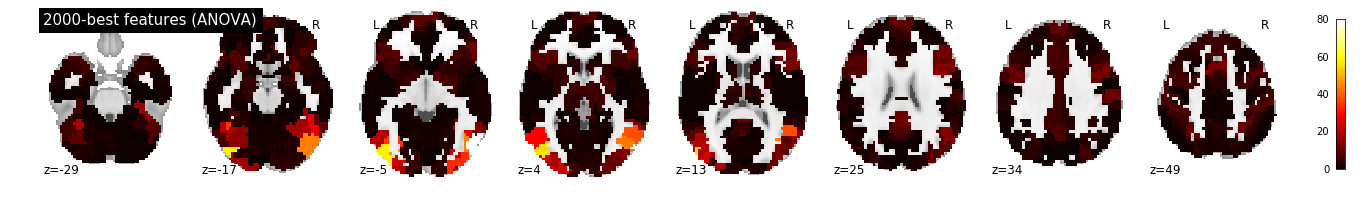

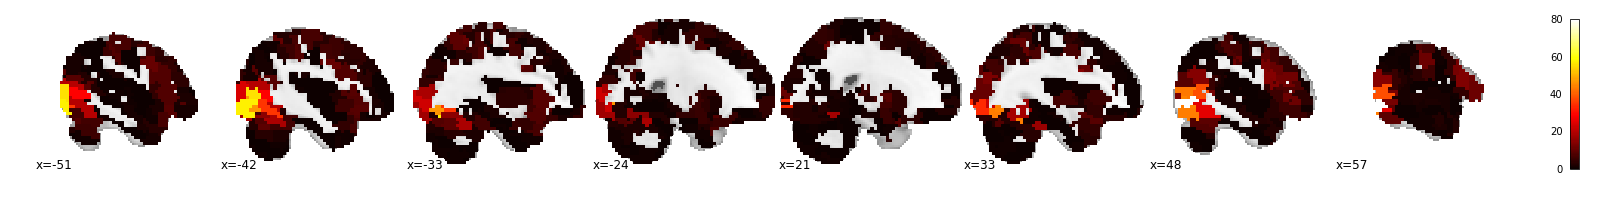

In [200]:
k=10
pipeline_anova.fit(X_train_lowhigh,y_train_lowhigh)
pvals = pipeline_anova.named_steps['anova'].pvalues_
logpvals = -np.log10(pvals)

plot_stat_map(masker.inverse_transform(logpvals.reshape((1,523))),cut_coords=8,display_mode='z',title='2000-best features (ANOVA)')
plt.show()
plot_stat_map(masker.inverse_transform(logpvals.reshape((1,523))),cut_coords=8,display_mode='x')
plt.show()

In [196]:
logpvals.shape

(523,)

In [25]:
gr.sample?